In [2]:
%%capture
%pip install geopandas

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import geopandas as gpd
import xgboost as xgb
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
from sklearn.cluster import KMeans
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
import time
from scipy import stats
#import pickle
%matplotlib inline

In [4]:
from google.colab import files
uploaded = files.upload()

Saving realadvisor_cs_sample.csv to realadvisor_cs_sample.csv


In [ ]:
housing=pd.read_csv('realadvisor_cs_sample.csv')

**I am assuming that the market at the end of 2019 is the same that at the beginning of 2020, therefore I am aiming to use a model that learn to predict prices depending on the date , then change the dates of the dataset to adjust the prices. Transactions will be clustered spatially using kmeans, then fed into a Xgboost regression model.** 


**Let's explore the data** 


In [ ]:
housing.head() 

,date_mutation,value,address_number,street,postcode,town,property_main_type,usable_surface,number_of_rooms,lon,lat
0,2019-12-31,119000,28,RUE FERNAND HERBAUT,93600,Aulnay-sous-Bois,APPT,30.0,2.0,2.49421,48.93404
1,2019-12-31,310000,5078,RTE NATIONALE 322,95270,Bellefontaine,HOUSE,132.0,6.0,2.46464,49.09899
2,2019-12-31,50000,263,LE BOURG,33350,Sainte-Terre,HOUSE,37.0,2.0,-0.11288,44.82749
3,2019-12-31,153000,119,RUE JEAN JAURES,33350,Saint-Magne-de-Castillon,HOUSE,130.0,6.0,-0.05210,44.84952
4,2019-12-31,240000,27,BD ALEXANDRE 3,6400,Cannes,APPT,32.0,1.0,7.03761,43.54663


**Dropping unneeded columns**

In [ ]:

housing=housing.drop(columns=['street','address_number','postcode','town'])

In [ ]:
housing.info() # no missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   date_mutation       100000 non-null  object 
 1   value               100000 non-null  int64  
 2   property_main_type  100000 non-null  object 
 3   usable_surface      100000 non-null  float64
 4   number_of_rooms     100000 non-null  float64
 5   lon                 100000 non-null  float64
 6   lat                 100000 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 5.3+ MB


In [ ]:
housing.describe() # basic stats of our variables

,value,usable_surface,number_of_rooms,lon,lat
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000
mean,2.214144e+05,86.199110,3.610840,2.079963,46.268957
std,2.449583e+05,47.522236,1.682683,6.719841,6.073744
min,3.600000e+02,1.000000,0.000000,-63.139520,-21.384520
25%,1.050000e+05,54.000000,2.000000,0.135850,44.801680
50%,1.662000e+05,80.000000,4.000000,2.326250,47.210465
75%,2.571108e+05,108.000000,5.000000,4.126145,48.818100
max,1.174965e+07,1000.000000,90.000000,55.768990,51.082010


**Boxplots**

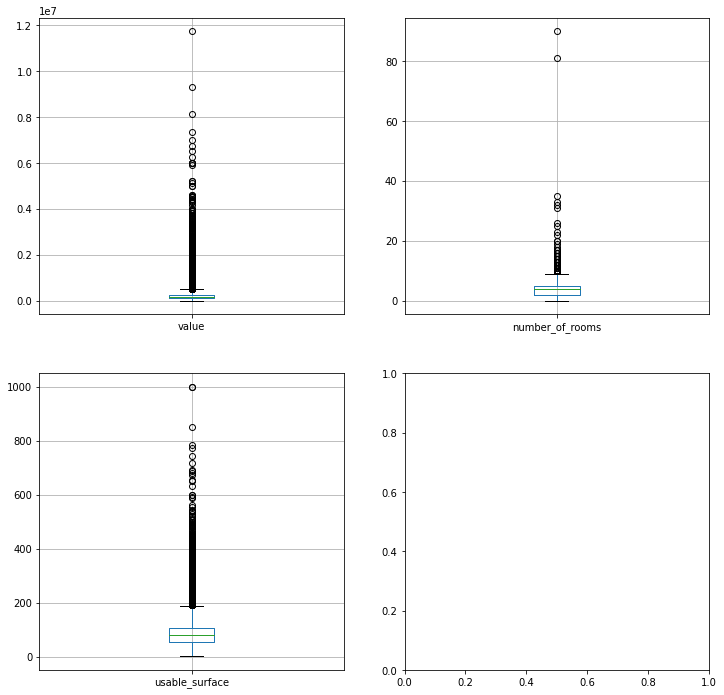

In [ ]:
#Boxplots of numerical variables

fig, axes = plt.subplots(nrows=2, ncols=2,figsize=[12,12])

housing.boxplot('value',ax=axes[0,0]) 
housing.boxplot('number_of_rooms',ax=axes[0,1])
housing.boxplot('usable_surface',ax=axes[1,0])

**Removing outliers (>99% percentile and < 1% percentile) and adding a new feature**

In [ ]:
low = 0.01
high = 0.99
quant_df = housing.quantile([low, high])



housing = housing.apply(lambda x: x[(x>quant_df.loc[low,x.name]) & (x <quant_df.loc[high,x.name])] 
                        if x.name in ('value','usable_surface','number_of_rooms') else x, axis=0)
housing=housing.dropna()
#adding a new feature
housing["surface_per_room"] = housing["usable_surface"]/housing["number_of_rooms"] 

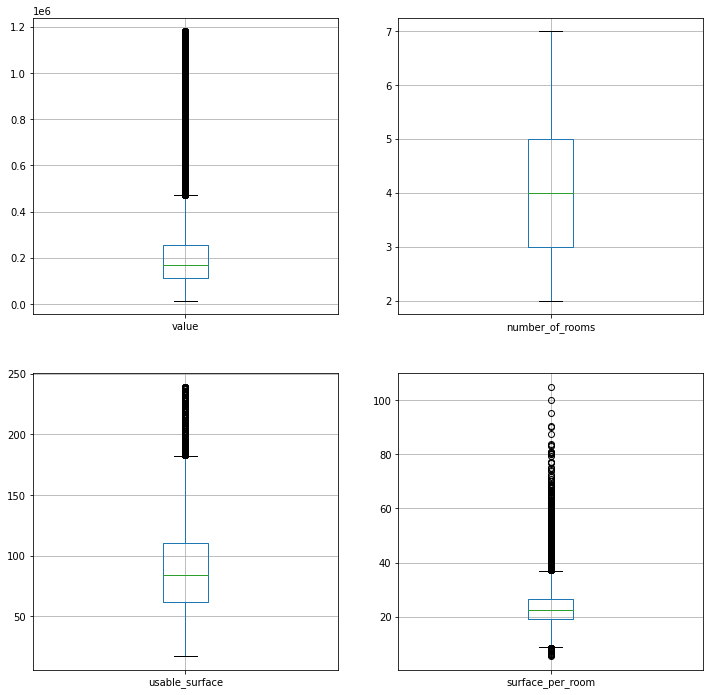

In [ ]:
#boxplots with less outliers
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=[12,12])

housing.boxplot('value',ax=axes[0,0]) 
housing.boxplot('number_of_rooms',ax=axes[0,1])
housing.boxplot('usable_surface',ax=axes[1,0])
housing.boxplot('surface_per_room',ax=axes[1,1])

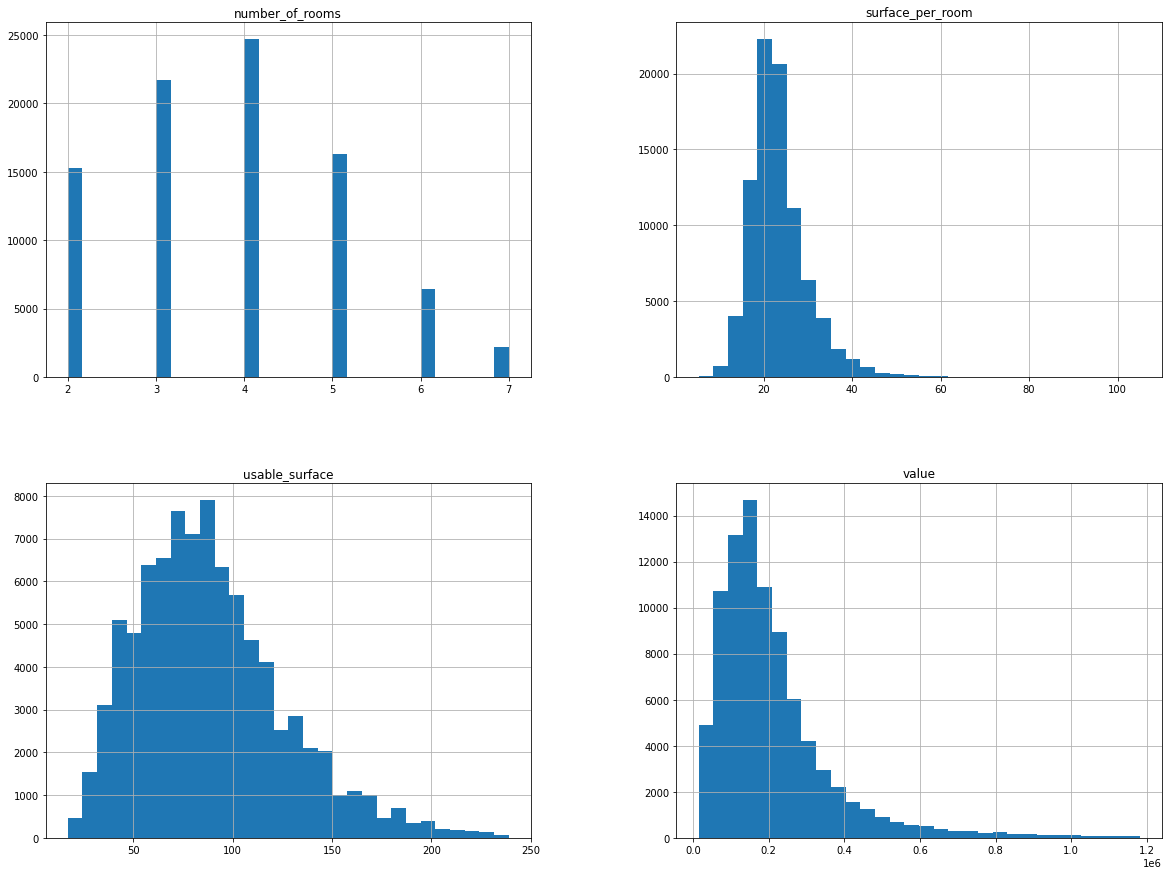

In [ ]:
housing.hist(['number_of_rooms','usable_surface','value','surface_per_room'], bins=30, figsize=(20,15))
plt.show()

#numerical variables are skewed to the right 

In [ ]:
corr_matrix=housing.corr()
corr_matrix["value"].sort_values(ascending=False)

value               1.000000
usable_surface      0.280394
number_of_rooms     0.198505
surface_per_room    0.152509
lon                 0.042583
lat                -0.020462
Name: value, dtype: float64

**Let's check where our transactions are located**

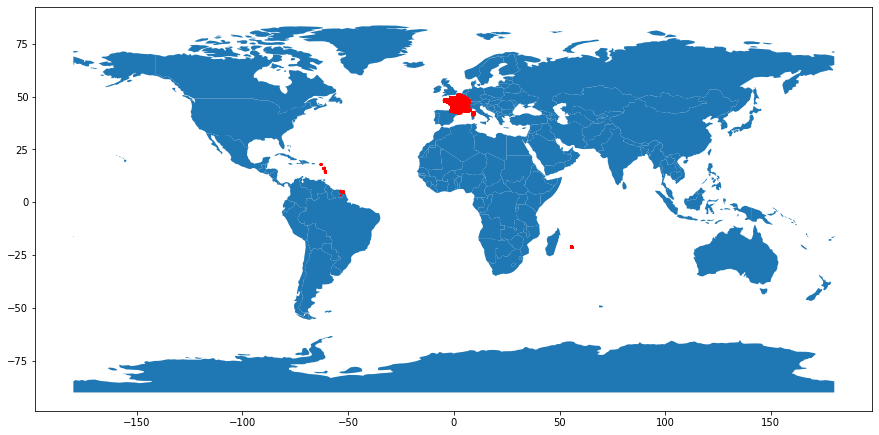

In [ ]:
#ploting the location of all the transaction on the world map 
housing_geo=housing.copy()
gdf = gpd.GeoDataFrame(housing_geo, geometry=gpd.points_from_xy(housing_geo.lon, housing_geo.lat))

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax=gdf.plot(ax=world.plot(figsize=(15, 15)), marker='o', color='red', markersize=1)


(40.0, 55.0)

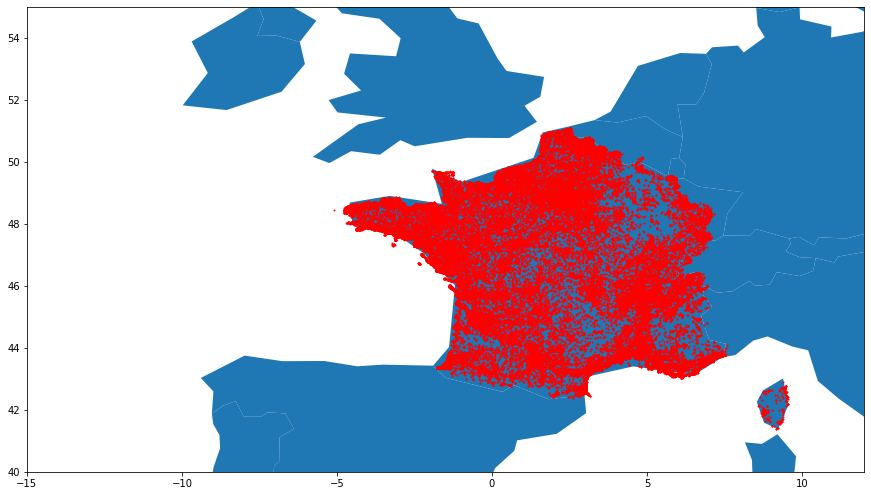

In [ ]:
#zooming on mainland France, we can see some sparse areas

ax=gdf.plot(ax=world.plot(figsize=(15, 15)), marker='o', color='red', markersize=1)
ax.set_xlim(-15, 12)
ax.set_ylim(40,55)

(2.0, 25.0)

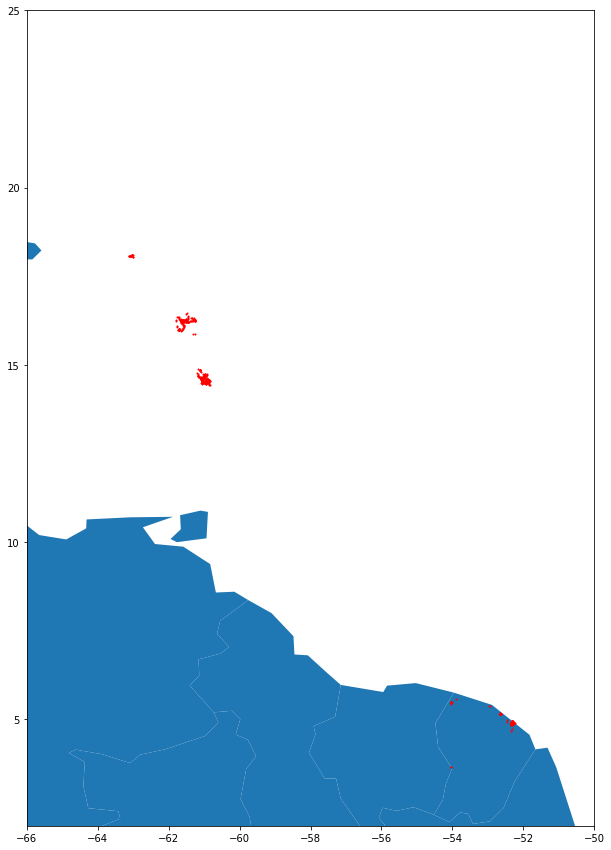

In [ ]:
#French west indies And French Guiana
ax=gdf.plot(ax=world.plot(figsize=(15, 15)), marker='o', color='red', markersize=1)
ax.set_xlim(-66,-50)
ax.set_ylim(2,25)

(-22.0, -20.0)

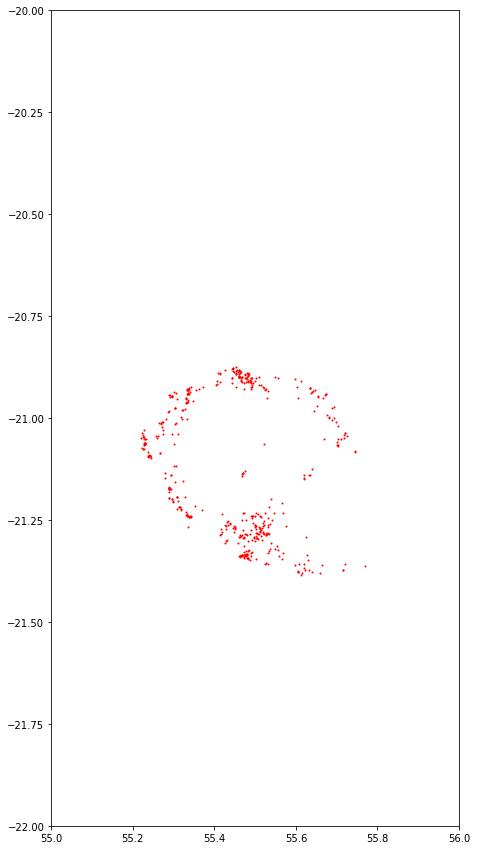

In [ ]:
#Reunion Island
ax=gdf.plot(ax=world.plot(figsize=(15, 15)), marker='o', color='red', markersize=1)
ax.set_xlim(55,56)
ax.set_ylim(-22,-20)

In [ ]:
#removing overseas territories
housing=housing.loc[(housing['lon']>-10) & (housing['lon']<10)]

In [ ]:
#parsing the date as two variables year and month
housing['year'] = pd.DatetimeIndex(housing['date_mutation']).year.copy()
housing['month'] = pd.DatetimeIndex(housing['date_mutation']).month.copy()
housing=housing.drop(['date_mutation'],axis=1)

**Let's set aside some random transactions from the end of 2019, as a test set**

In [ ]:
#retrieving end of 2019 transactions
housing_2019=housing.loc[(housing['year']== 2019) & ((housing['month']== 12)| (housing['month']== 11))| (housing['month']== 10)]
#random split of these transactions
train_2019, test_2019 = train_test_split(housing_2019, test_size=0.1, random_state=42)
#droping 10% of these transactions which we will use as the testing set
housing = housing.drop(test_2019.index, axis=0) 

#separating labels(prices) and features
housing_labels = housing["value"].copy()
housing_features=housing.drop(["value"],axis=1)

#separating lat/lon
coord=housing_features[['lon','lat']].copy()
housing_features=housing_features.drop(['lon','lat'],axis=1)

**Pipeline for numerical variables**

In [ ]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Preprocessing pipeline for the numerical values 
num_pipeline = Pipeline([
                    ('imputer', SimpleImputer(strategy="median")), #in case of missing values
                    ('log_scaler', FunctionTransformer(np.log)), #taking the log to have less skewed data and a better scale
                       ])


housing_num=housing[['number_of_rooms','usable_surface','surface_per_room']]
housing_num_tr = num_pipeline.fit_transform(housing_num)
df = pd.DataFrame(data=housing_num_tr,columns=['usable_surface','number_of_rooms','surface_per_room'])

**Transformed feautres are less skewed and have a more similar scale**

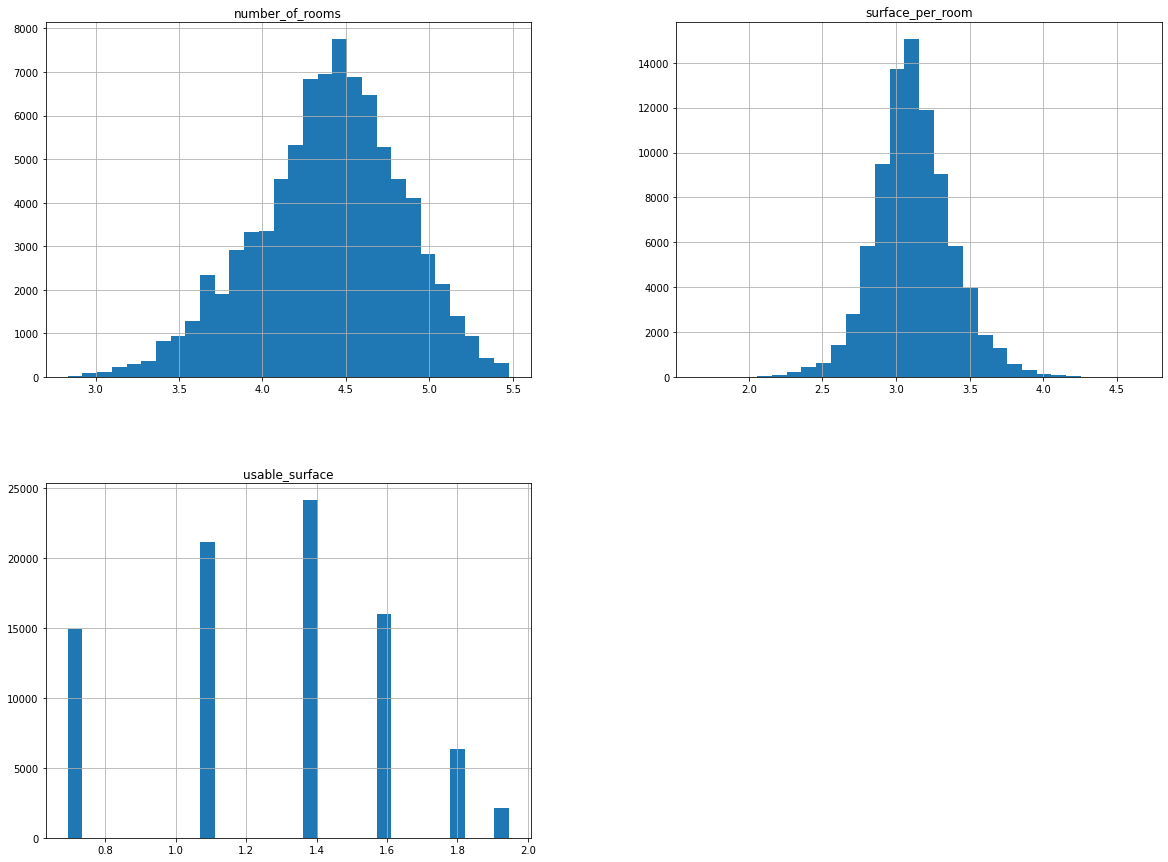

In [ ]:
df.hist(['number_of_rooms','usable_surface','surface_per_room'], bins=30, figsize=(20,15))
plt.show()

**Now we will use Kmeans to clusterize our transactions based on their spatials coordonates**


In [ ]:
#Using Kmeans to clusterize transactions , based only on longitute/latitute
coord=housing[['lon','lat']].copy()
kmeans = KMeans(n_clusters = 13, init ='k-means++')
coord['cluster_label'] = kmeans.fit_predict(coord[['lon','lat']]) #adding cluster labels 
labels = kmeans.predict(coord[coord.columns[0:2]]) # Labels of each point
coord.head(10)

,lon,lat,cluster_label
0,2.49421,48.93404,6
1,2.46464,49.09899,6
2,-0.11288,44.82749,7
3,-0.05210,44.84952,7
5,2.38728,48.96894,6
7,-1.48407,47.24417,8
8,2.83169,46.16594,10
9,2.97546,46.11469,10
11,-1.46762,49.50717,9
12,-2.15932,47.97596,8


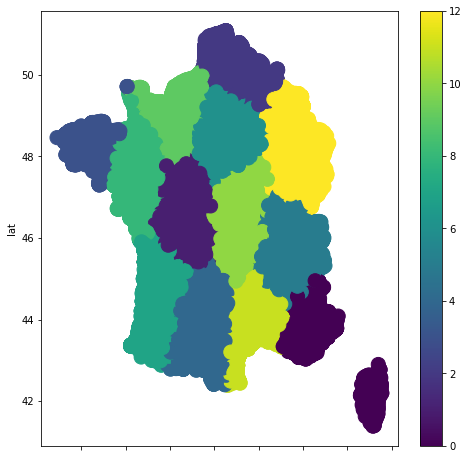

In [ ]:
coord.plot.scatter(x = 'lon', y = 'lat', c=labels, s=200, cmap='viridis',figsize=[8,8])

In [ ]:
#adding these cluster ids id to our dataset ( a new categorical variable)
housing_features['cluster_label']=coord['cluster_label']

**Using sklearn to make a preprocessing pipeline for our variables**

In [ ]:
from sklearn.compose import ColumnTransformer

#full pipeline for preprocessing numerical and categorical variables
#log scaler for numerical variable, and one hot encoding for categorical ones
num_attribs = ['usable_surface','number_of_rooms','surface_per_room']
cat_attribs = ["property_main_type","year","month","cluster_label"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing_features)

In [ ]:
#Now we have a sparse matrix
housing_prepared

<84711x36 sparse matrix of type '<class 'numpy.float64'>'
	with 592977 stored elements in Compressed Sparse Row format>

In [ ]:
housing_prepared[0].toarray()

array([[3.40119738, 0.69314718, 2.7080502 , 1.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 1.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ]])

**Now we can feed our data into a machine learning algorothm, I decided to use XGBoost**

In [ ]:
X = housing_prepared
Y = housing_labels.values

#XGB gamma regression 
xgb_model = xgb.XGBRegressor(objective='reg:gamma',silent=True,early_stopping_rounds=200,tree_method='gpu_hist')
params = {
        'n_estimators': stats.randint(1500, 4000),
        'learning_rate': [0.03,0.04,0.05,0.06],
        'min_child_weight': [1,2,3,4,5],
        'gamma': [4,5,6,7,8],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [4,5,6,7],
        'reg_alpha':[0.75,0.80],
        'reg_lambda':[0.75,0.80] 

        }

**Let's do a 4 fold stratified cross validation with random search**

In [ ]:
folds = 4
param_comb = 4 # iteration per fold

skf = StratifiedKFold(n_splits=folds, shuffle = True)

random_search = RandomizedSearchCV(xgb_model,param_distributions=params,n_iter=param_comb, 
                                   scoring='neg_mean_squared_log_error', n_jobs=1, cv=skf.split(X,Y), verbose=3, random_state=42)

In [ ]:
start_time = time.time() 
random_search.fit(X, Y)
end_time=time.time()-start_time
print("time:" ,end_time)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)


Fitting 4 folds for each of 4 candidates, totalling 16 fits
[CV] colsample_bytree=1.0, gamma=7, learning_rate=0.03, max_depth=6, min_child_weight=3, n_estimators=2595, reg_alpha=0.75, reg_lambda=0.75, subsample=1.0 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  colsample_bytree=1.0, gamma=7, learning_rate=0.03, max_depth=6, min_child_weight=3, n_estimators=2595, reg_alpha=0.75, reg_lambda=0.75, subsample=1.0, score=-0.357, total=  26.8s
[CV] colsample_bytree=1.0, gamma=7, learning_rate=0.03, max_depth=6, min_child_weight=3, n_estimators=2595, reg_alpha=0.75, reg_lambda=0.75, subsample=1.0 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   26.8s remaining:    0.0s


[CV]  colsample_bytree=1.0, gamma=7, learning_rate=0.03, max_depth=6, min_child_weight=3, n_estimators=2595, reg_alpha=0.75, reg_lambda=0.75, subsample=1.0, score=-0.359, total=  26.8s
[CV] colsample_bytree=1.0, gamma=7, learning_rate=0.03, max_depth=6, min_child_weight=3, n_estimators=2595, reg_alpha=0.75, reg_lambda=0.75, subsample=1.0 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   53.7s remaining:    0.0s


[CV]  colsample_bytree=1.0, gamma=7, learning_rate=0.03, max_depth=6, min_child_weight=3, n_estimators=2595, reg_alpha=0.75, reg_lambda=0.75, subsample=1.0, score=-0.360, total=  26.9s
[CV] colsample_bytree=1.0, gamma=7, learning_rate=0.03, max_depth=6, min_child_weight=3, n_estimators=2595, reg_alpha=0.75, reg_lambda=0.75, subsample=1.0 
[CV]  colsample_bytree=1.0, gamma=7, learning_rate=0.03, max_depth=6, min_child_weight=3, n_estimators=2595, reg_alpha=0.75, reg_lambda=0.75, subsample=1.0, score=-0.362, total=  27.0s
[CV] colsample_bytree=0.8, gamma=6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=3635, reg_alpha=0.75, reg_lambda=0.8, subsample=1.0 
[CV]  colsample_bytree=0.8, gamma=6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=3635, reg_alpha=0.75, reg_lambda=0.8, subsample=1.0, score=-0.364, total=  38.2s
[CV] colsample_bytree=0.8, gamma=6, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=3635, reg_alpha=0.75, reg_lambda=

[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:  9.2min finished


time: 572.2019639015198


In [ ]:
print(random_search.best_estimator_)
print("neg RMSLE loss :",random_search.best_score_)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6,
             early_stopping_rounds=200, gamma=7, importance_type='gain',
             learning_rate=0.04, max_delta_step=0, max_depth=5,
             min_child_weight=5, missing=None, n_estimators=2247, n_jobs=1,
             nthread=None, objective='reg:gamma', random_state=0,
             reg_alpha=0.75, reg_lambda=0.75, scale_pos_weight=1, seed=None,
             silent=True, subsample=1.0, tree_method='gpu_hist', verbosity=1)
neg RMSLE loss : -0.3581561978556084


**Now let's see the loss on the test set**

In [ ]:
Ytest=test_2019['value'].copy()
Xtest=test_2019.drop('value',axis=1)

Xtest['cluster_label'] = kmeans.predict(Xtest[['lon','lat']]) #predict clusters id
Xtest=Xtest.drop(['lon','lat'],axis=1)

Xtest_prepared=full_pipeline.transform(Xtest) #transform test set with our pipeline

In [ ]:
from sklearn.metrics import mean_squared_log_error
y_pred=random_search.predict(Xtest_prepared)
print("RMSLE loss:", mean_squared_log_error(Ytest,y_pred))

RMSLE loss: 0.32808936920247683


**Now we can use this model to adjust prices by changing all the dates to  december 2019**

In [ ]:
fullset_topred=pd.concat([housing_features,Xtest],sort=False).sort_index() #putting back the train and test set together


In [ ]:
fullset_topred['year']=2019 #changing every year to 2019
fullset_topred['month']=12 # changing every month to december
fullset_topred.tail()

,property_main_type,usable_surface,number_of_rooms,surface_per_room,year,month,cluster_label
99995,APPT,59.0,3.0,19.666667,2019,12,8
99996,HOUSE,102.0,4.0,25.500000,2019,12,8
99997,HOUSE,64.0,2.0,32.000000,2019,12,7
99998,APPT,97.0,4.0,24.250000,2019,12,0
99999,HOUSE,98.0,3.0,32.666667,2019,12,10


In [ ]:
full_prepared=full_pipeline.transform(fullset_topred) #transforming the dataset with our pipeline
my_preds=random_search.predict(full_prepared) # predicting 

In [ ]:
full_prepared.toarray()[0]

array([3.40119738, 0.69314718, 2.7080502 , 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        ])

In [ ]:
my_preds[0:5]

array([308279.3 , 350099.3 , 128848.15, 289119.25, 358096.9 ],
      dtype=float32)

**Let's put our predictions on a csv file**

In [ ]:
hs=pd.read_csv('realadvisor_cs_sample.csv') #load the whole dataset once again

In [ ]:
#Removing outliers and overseas territories
hs = hs.apply(lambda x: x[(x>quant_df.loc[low,x.name]) & (x <quant_df.loc[high,x.name])] 
                        if x.name in ('value','usable_surface','number_of_rooms') else x, axis=0)
hs=hs.dropna()
hs=hs.loc[(hs['lon']>-10) & (hs['lon']<10)]

In [ ]:
hs['predictions']=my_preds #adding our prediction to the dataset

In [ ]:
hs.to_csv('preds.csv')

In [ ]:
files.download("preds.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>